<a href="https://colab.research.google.com/github/nknigam/MachineLearning/blob/master/StockMarket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import datetime
import os
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
from sklearn import metrics

import matplotlib.pyplot as plt
from scipy import stats

import tensorflow as tf
from tensorflow import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, save_model

import seaborn as sns
from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

In [26]:
#display parent directory and working directory
print(os.path.dirname(os.getcwd())+':', os.listdir(os.path.dirname(os.getcwd())));
print(os.getcwd()+':', os.listdir(os.getcwd()));

/: ['root', 'sbin', 'media', 'var', 'etc', 'proc', 'sys', 'opt', 'dev', 'usr', 'mnt', 'run', 'bin', 'lib64', 'tmp', 'boot', 'home', 'srv', 'lib', 'content', '.dockerenv', 'datalab', 'tools', 'swift', 'tensorflow-1.15.2', 'lib32']
/content: ['.config', 'HDFCBANK.csv', 'sample_data']


# Analyze HDFC Bank daily Stock price

In [124]:
df = pd.read_csv("HDFCBANK.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5184 entries, 0 to 5183
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                5184 non-null   object 
 1   Symbol              5184 non-null   object 
 2   Series              5184 non-null   object 
 3   Prev Close          5184 non-null   float64
 4   Open                5184 non-null   float64
 5   High                5184 non-null   float64
 6   Low                 5184 non-null   float64
 7   Last                5184 non-null   float64
 8   Close               5184 non-null   float64
 9   VWAP                5184 non-null   float64
 10  Volume              5184 non-null   int64  
 11  Turnover            5184 non-null   float64
 12  Trades              2334 non-null   float64
 13  Deliverable Volume  4675 non-null   float64
 14  %Deliverble         4675 non-null   float64
dtypes: float64(11), int64(1), object(3)
memory usage: 607.6

In [125]:
plot_x = df['Date'].copy()
df.set_index("Date", inplace = True)
df.index = pd.to_datetime(df.index)
df.tail()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2020-10-26,HDFCBANK,EQ,1235.8,1229.80,1242.00,1204.60,1216.55,1210.90,1222.29,9786023,1.196138e+15,197782.0,4286264.0,0.4380
2020-10-27,HDFCBANK,EQ,1210.9,1226.00,1236.00,1197.85,1235.00,1233.10,1216.83,12158922,1.479529e+15,207342.0,5566363.0,0.4578
2020-10-28,HDFCBANK,EQ,1233.1,1228.00,1232.00,1201.50,1210.30,1209.60,1214.22,8285625,1.006059e+15,202965.0,3816626.0,0.4606
2020-10-29,HDFCBANK,EQ,1209.6,1200.60,1204.45,1178.50,1190.50,1187.20,1189.63,11530152,1.371666e+15,207330.0,4599106.0,0.3989
2020-10-30,HDFCBANK,EQ,1187.2,1182.55,1199.30,1176.35,1182.40,1183.55,1186.31,5761470,6.834879e+14,137766.0,1417497.0,0.2460


In [126]:
df.describe()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
count,5184.000000,5184.000000,5184.000000,5184.000000,5184.000000,5184.000000,5184.000000,5.184000e+03,5.184000e+03,2334.000000,4.675000e+03,4675.000000
mean,996.597290,996.897955,1009.320679,983.409587,996.805883,996.795235,996.390808,1.901490e+06,2.144259e+14,74504.353042,1.164452e+06,0.598526
std,639.324343,638.966383,644.991685,633.027057,639.254264,639.223311,639.020034,3.744284e+06,4.317437e+14,86516.143550,1.975154e+06,0.120262
min,157.400000,162.150000,167.900000,157.000000,163.000000,163.400000,161.400000,1.042000e+03,2.291142e+10,807.000000,4.631000e+03,0.177900
25%,468.312500,469.875000,475.600000,461.875000,470.000000,469.112500,468.962500,2.917712e+05,1.505309e+13,26230.750000,2.551265e+05,0.524900
50%,911.600000,915.025000,930.825000,893.325000,912.200000,911.750000,911.855000,9.077695e+05,1.109204e+14,41848.500000,6.098440e+05,0.604300
75%,1384.362500,1390.000000,1409.450000,1360.000000,1388.100000,1384.362500,1384.995000,2.008752e+06,2.051019e+14,86674.750000,1.331341e+06,0.676200
max,2565.800000,2566.000000,2583.300000,2553.700000,2563.000000,2565.800000,2570.700000,1.005650e+08,1.426400e+16,790631.000000,6.669683e+07,1.000000


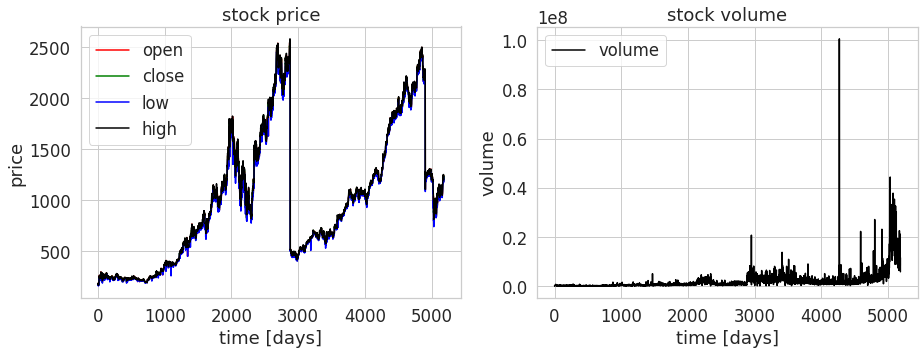

In [127]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df['Open'].values, color='red', label='open')
plt.plot(df['Close'].values, color='green', label='close')
plt.plot(df['Low'].values, color='blue', label='low')
plt.plot(df['High'].values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df['Volume'].values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

# Manipulate Data


1.   Drop features: Deliverable Volume,	%Deliverble
2.   Normalize Stock data
3.   Create train, validation and test dataset







In [121]:
x_scaler = sklearn.preprocessing.MinMaxScaler()
y_scaler = sklearn.preprocessing.MinMaxScaler()

In [71]:
def load_data(X, seq_len, train_size=0.9):
    amount_of_features = X.shape[1]
    X_mat = X.values
    sequence_length = seq_len + 1
    data = []
    
    for index in range(len(X_mat) - sequence_length):
        data.append(X_mat[index: index + sequence_length])
    
    data = np.array(data)
    train_split = int(round(train_size * data.shape[0]))
    train_data = data[:train_split, :]
    
    x_train = train_data[:, :-1]
    y_train = train_data[:, -1][:,-1]
    
    x_test = data[train_split:, :-1] 
    y_test = data[train_split:, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return x_train, y_train, x_test, y_test


In [129]:
# normalize stock
X = df[['Open', 'High', 'Low', 'Volume']].copy()
y = df['Close'].copy()

X[['Open', 'High', 'Low', 'Volume']] = x_scaler.fit_transform(x)
y = y_scaler.fit_transform(y.values.reshape(-1,1))

cols =  list(X.columns.values)
print ('x.columns.values = ', cols)

x.columns.values =  ['Open', 'High', 'Low', 'Volume']


In [134]:
#X = df_stock_norm.copy() #[['Open', 'High', 'Low', 'Volume']].copy()
#y = df_stock_norm['Close'].copy()

# X.info()
#y_inverse = y_scaler.inverse_transform(y)
#y_inverse

X['Close'] = y

In [135]:
# create train, test data

window = 20

X_train, y_train, X_test, y_test = load_data(X, window)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print (X_train[0], y_train[0])

(4647, 20, 5) (4647,) (516, 20, 5) (516,)
[[1.60159744e-03 8.69421214e-04 3.75516335e-03 3.20363317e-04
  2.74725275e-03]
 [8.25758679e-03 6.43785708e-03 5.84136521e-03 1.66727742e-03
  4.32900433e-03]
 [3.26559478e-03 2.48406061e-03 3.33792298e-03 1.57887596e-03
  1.47768898e-03]
 [2.43359611e-03 8.69421214e-04 3.46309509e-03 8.35130299e-04
  2.03962704e-03]
 [0.00000000e+00 1.28343132e-03 2.14878792e-03 8.36303682e-04
  2.06043956e-03]
 [4.47199284e-03 4.80251718e-03 3.33792298e-03 9.88346241e-04
  1.04062604e-03]
 [1.80959710e-03 0.00000000e+00 0.00000000e+00 1.43930308e-03
  0.00000000e+00]
 [6.65598935e-04 2.07005051e-05 2.21137397e-03 8.44338371e-04
  8.53313353e-04]
 [3.22399484e-03 8.28020204e-04 3.33792298e-03 4.69691186e-04
  7.07625708e-04]
 [2.43359611e-03 4.14010102e-05 2.92068261e-03 5.67897354e-04
  8.53313353e-04]
 [4.92959211e-03 4.47130910e-03 6.27946760e-03 1.35597302e-03
  6.36863137e-03]
 [6.88478898e-03 4.47130910e-03 3.15016481e-03 2.53182184e-03
  9.57375957e-04

In [136]:
print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)

print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (4647, 20, 5)
y_train.shape =  (4647,)
X_test.shape =  (516, 20, 5)
y_test.shape =  (516,)


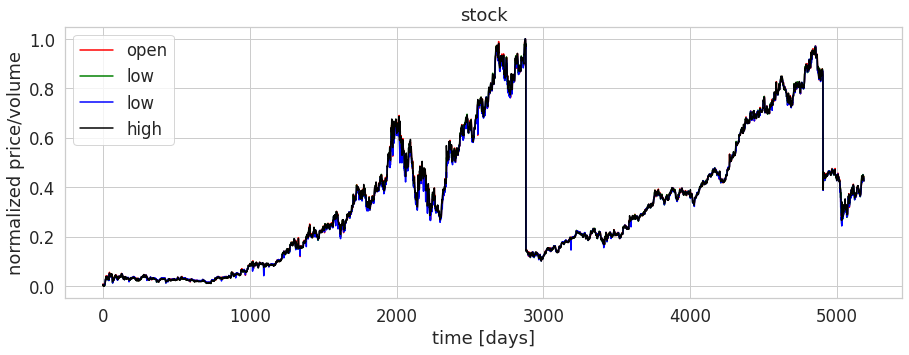

In [137]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.Open.values, color='red', label='open')
plt.plot(df_stock_norm.Close.values, color='green', label='low')
plt.plot(df_stock_norm.Low.values, color='blue', label='low')
plt.plot(df_stock_norm.High.values, color='black', label='high')
#plt.plot(df_stock_norm.Volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

# Model and Validate data

## Basic cells with RNN in tensorflow



In [139]:
# parameters
n_inputs = 5
learning_rate = 0.001
n_batch_size = 50
n_epochs = 500 

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [140]:
input_shape = [window, n_inputs]
d = 0.2
path = "model.h5"
ck_file = "model_ch_pt.h5"

if os.path.exists(path):
  print('loading model - ', path)
  model = keras.models.load_model(path) # Loading the model
  if os.path.exists(ck_file):
    print('loading checkpoint weights - ', ck_file)
    model.load_weights(ck_file)  # loading the saved weights
else:
  # build_model
  model = keras.models.Sequential([
      LSTM(128, input_shape=input_shape, return_sequences=True),
      Dropout(d),
      LSTM(128, input_shape=input_shape, return_sequences=False),
      Dropout(d),
      Dense(32, kernel_initializer='uniform', activation='relu'),
      Dense(1, kernel_initializer='uniform', activation='linear')
  ])
  model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
  print('saving model - ', path)
  model.save(path)

saving model -  model.h5


In [141]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 128)           68608     
_________________________________________________________________
dropout (Dropout)            (None, 20, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 204,353
Trainable params: 204,353
Non-trainable params: 0
__________________________________________________

In [144]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(ck_file, save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=n_batch_size, epochs=n_epochs, 
                    validation_split=0.3, 
                    callbacks=[checkpoint_cb, early_stopping_cb])
model.save(path)

Epoch 1/500
66/66 [==============================] - 5s 83ms/step - loss: 8.1644e-04 - accuracy: 3.0750e-04 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 2/500
66/66 [==============================] - 5s 83ms/step - loss: 9.6081e-04 - accuracy: 3.0750e-04 - val_loss: 1.7619e-04 - val_accuracy: 0.0000e+00
Epoch 3/500
66/66 [==============================] - 5s 83ms/step - loss: 7.4934e-04 - accuracy: 3.0750e-04 - val_loss: 4.7297e-05 - val_accuracy: 0.0000e+00
Epoch 4/500
66/66 [==============================] - 5s 81ms/step - loss: 7.1984e-04 - accuracy: 3.0750e-04 - val_loss: 5.7568e-04 - val_accuracy: 0.0000e+00
Epoch 5/500
66/66 [==============================] - 5s 82ms/step - loss: 8.6860e-04 - accuracy: 3.0750e-04 - val_loss: 1.2071e-04 - val_accuracy: 0.0000e+00
Epoch 6/500
66/66 [==============================] - 5s 81ms/step - loss: 5.8913e-04 - accuracy: 3.0750e-04 - val_loss: 2.0394e-04 - val_accuracy: 0.0000e+00
Epoch 7/500
66/66 [==============================] - 5s 

In [149]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print(train_predict.shape)
print(test_predict.shape)

(4647, 20, 5)
(516, 20, 5)
(4647,)
(516,)
(4647, 1)
(516, 1)


In [150]:
train_predict = y_scaler.inverse_transform(train_predict)
trainY = y_scaler.inverse_transform([y_train])

test_predict = y_scaler.inverse_transform(test_predict)
testY = y_scaler.inverse_transform([y_test])

In [158]:
test_size = y_test.shape[0]
#print(test_predict.shape)
#print(testY.shape)
test_predict = test_predict.reshape(test_size, 1)
test_actual = testY.reshape(test_size, 1)


In [159]:
print(test_predict.shape)
print(test_actual.shape)

(516, 1)
(516, 1)


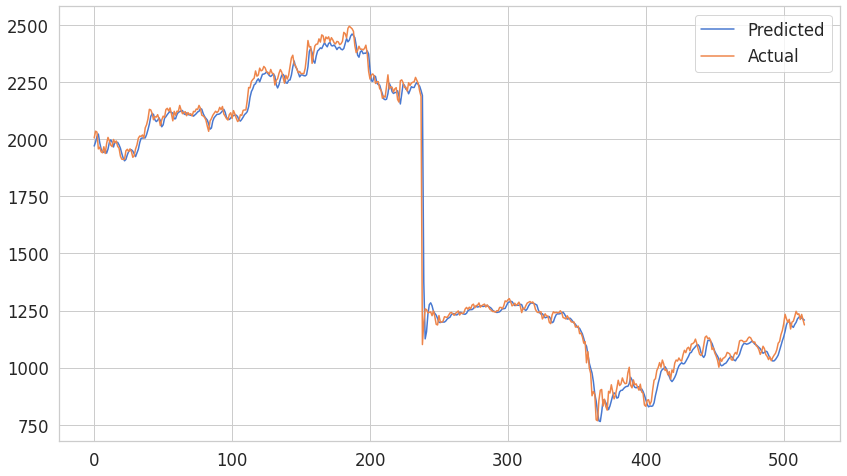

In [160]:
plt.plot(pd.DataFrame(test_predict), label='Predicted')
plt.plot(pd.DataFrame(test_actual), label='Actual')
plt.legend(loc='best')
plt.show()

In [173]:
print(trainY[0].shape)
print(train_predict.shape)

print(testY[0].shape)
print(test_predict[:,0].shape)

(4647,)
(4647, 1)
(516,)
(516,)


In [172]:
trainScore = keras.metrics.mean_squared_error(trainY[0], train_predict[:,0]) ** 0.5
print ('Train Score: %.2f RMSE ' % (trainScore))

testScore = keras.metrics.mean_squared_error(testY[0], test_predict[:,0]) ** 0.5
print ('Test Score: %.2f RMSE ' % (testScore))

Train Score: 38.61 RMSE 
Test Score: 58.31 RMSE 
